In [3]:
import numpy as np
import pandas as pd
import os
import re
import datetime as dt
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import BDay
from uuid import uuid4
import matplotlib.pyplot as plt
import pmdarima
import math

# !pip install pmdarima

current_path = os.getcwd()
os.chdir(current_path)

# import Rolling_Algo_SG as rsg

'''
sic data retrieve lib import
-------------------
'''

'\nsic data retrieve lib import\n-------------------\n'

In [7]:
os.getcwd()

'/shared/Self_Insure'

In [8]:
os.chdir('/shared/Self_Insure/')

In [6]:
from falcon.loader import sic as sic_loader
from falcon.scenario_generators.SARIMA import SARIMA
from falcon.scenario_generators.main import generate_sim_dates as data_date
from falcon.scenario_generators.portfolio_tools import PortfolioTool
from falcon.scenario_generators.HistoricalSimulationV4 import HistoricalSimulation as HS

In [9]:
from HistoricalSimulation_platform import HistoricalSimulation as HS_p

In [1]:
# get data in list format
sic_str = 'US3319'
frequency = 'M'
datetime_anchor = pd.to_datetime('2024-10-01')
details, sic_data, _ = sic_loader.DataCenter.load_sic_data_db(sic_str, drop_extension=False)
sic_data = sic_data[sic_data.index <= datetime_anchor]
sic_data = sic_data[sic_data.index >= pd.to_datetime('2012-01-01')]
sic_data = sic_data.resample('ME').mean()
sic_data = np.exp(np.log(sic_data).interpolate())
sic_log = np.log(sic_data)
sic_log = sic_log.iloc[1:]
sic_log = list(sic_log[sic_str])

NameError: name 'pd' is not defined

In [38]:
sic_log

[3.3371525657925734,
 3.317074391248395,
 3.2633275874390346,
 3.253277251585533,
 3.239611723347379,
 3.530363198405819,
 3.5158007644011593,
 3.462382070701295,
 3.3736278276239813,
 3.215536923602686,
 3.2124918542582774,
 3.2997279214972957,
 3.2108436531709366,
 2.9130592981629593,
 2.945691327482906,
 3.3030127040744004,
 3.6276687230690396,
 3.7736226356921194,
 3.3931944287993536,
 3.899638946228424,
 4.218956082472039,
 3.3375473545856993,
 3.24426505887302,
 3.2367157429965316,
 3.5893498587669033,
 3.557209681636114,
 3.5687911317458663,
 3.7190999967568206,
 3.8056518782643955,
 3.8182616256136717,
 4.121332170964988,
 4.254060086682767,
 3.7562042685001904,
 3.1669631436537875,
 3.6216707044204863,
 3.449609545449086,
 3.34109345759245,
 3.407841924380824,
 3.5624655292582776,
 3.4521497088360826,
 3.42045519826657,
 3.571542747409394,
 3.9599057285189745,
 3.543371870442698,
 3.3472690396365996,
 3.8229041460989515,
 3.1553624191458747,
 3.3239286008713442,
 3.26465393856

In [10]:
def percentiles_as_dict(forecasts) -> dict:
    percentiles = {
        "min": np.min(forecasts, axis=1).tolist(),
        "5per": np.percentile(forecasts, 5, axis=1).tolist(),
        "10per": np.percentile(forecasts, 10, axis=1).tolist(),
        "20per": np.percentile(forecasts, 20, axis=1).tolist(),
        "30per": np.percentile(forecasts, 25, axis=1).tolist(),
        "40per": np.percentile(forecasts, 35, axis=1).tolist(),
        "50per": np.percentile(forecasts, 50, axis=1).tolist(),
        "60per": np.percentile(forecasts, 65, axis=1).tolist(),
        "70per": np.percentile(forecasts, 75, axis=1).tolist(),
        "80per": np.percentile(forecasts, 80, axis=1).tolist(),
        "90per": np.percentile(forecasts, 90, axis=1).tolist(),
        "95per": np.percentile(forecasts, 95, axis=1).tolist(),
        "max": np.max(forecasts, axis=1).tolist(),
        "mean": np.mean(forecasts, axis=1).tolist(),
        "std": np.std(forecasts, axis=1).tolist(),
    }
    return percentiles

In [11]:
def filtered_hs_bootstrap_seasonal(data, freq,
         sim_length = 18, n_sims = 200):
    model = HS_p(filtering=True, bootstrap=True,weighting=f"S{freq}")
    model.fit(data)
    forecasts = model.simulate(sim_length, num_paths=n_sims)
    percentiles = percentiles_as_dict(forecasts)
    # sort columns by mean: forecasts: n_sims x forecast_length
    # Compute the average of each column
    column_averages = np.mean(forecasts, axis=0)
    # Get the indices that would sort the columns based on their average
    sorted_indices = np.argsort(column_averages)
    # Sort the array columns based on the sorted indices
    forecasts = forecasts[:, sorted_indices]
    forecasts = forecasts.tolist()
    n_sims = len(forecasts[0])
    # create the return messages
    msg = {
        "generator_code_name": "filtered_hs_bootstrap_seasonal",
        "run_time": datetime.utcnow(),
        "raw_data": data,
        "sim_length": sim_length,
        "n_sims": n_sims,
        "status": "success",
        "forecast": forecasts,
        "percentiles": percentiles,
    }
    return msg

In [12]:
def hs_bootstrap_seasonal(data, freq,
         sim_length = 18, n_sims = 200):
    model = HS_p(bootstrap=True, weighting=f"S{freq}")
    model.fit(data)
    forecasts = model.simulate(sim_length, num_paths=n_sims)
    percentiles = percentiles_as_dict(forecasts)
    # sort columns by mean: forecasts: n_sims x forecast_length
    # Compute the average of each column
    column_averages = np.mean(forecasts, axis=0)
    # Get the indices that would sort the columns based on their average
    sorted_indices = np.argsort(column_averages)
    # Sort the array columns based on the sorted indices
    forecasts = forecasts[:, sorted_indices]
    forecasts = forecasts.tolist()
    n_sims = len(forecasts[0])
    # create the return messages
    msg = {
        "generator_code_name": "hs_bootstrap_seasonal",
        "run_time": datetime.utcnow(),
        "raw_data": data,
        "sim_length": sim_length,
        "n_sims": n_sims,
        "status": "success",
        "forecast": forecasts,
        "percentiles": percentiles,
    }
    return msg

In [13]:
import statsmodels
def sarima(data, order,
           sim_length = 18, n_sims = 200):
    # run the sarima model
    # order: [p, d, q, P, D, Q, s] where s is the seasonal period

    # model fitting
    AR, D, MA, SAR, SD, SMA, SS = order
    model = statsmodels.api.tsa.statespace.SARIMAX(data, trend='c', order=(AR, D, MA), seasonal_order=(SAR, SD, SMA, SS))
    sarima_res = model.fit(disp=0)
    forecasts = np.array(
        [sarima_res.simulate(sim_length, anchor='end') for x in range(n_sims)]).T
    percentiles = percentiles_as_dict(forecasts)
    # sort columns by mean: forecasts: n_sims x forecast_length
    # Compute the average of each column
    column_averages = np.mean(forecasts, axis=0)
    # Get the indices that would sort the columns based on their average
    sorted_indices = np.argsort(column_averages)
    # Sort the array columns based on the sorted indices
    forecasts = forecasts[:, sorted_indices]
    forecasts = forecasts.tolist()

    # save results
    msg = {"generator_code_name": "sarima", "run_time": datetime.utcnow(), "raw_data": data, "sim_length": sim_length,
           "n_sims": n_sims, "status": "success", "stats_tests": {
            'AIC_BIC_HQIC': sarima_res.aic + sarima_res.bic + sarima_res.hqic,
            'AIC_BIC': sarima_res.aic + sarima_res.bic,
            'HQIC': sarima_res.hqic,
            'std_resid': np.nanstd(sarima_res.resid),
            'sarima_summary': sarima_res.summary().as_text(),
        }, "model_parameters": {
            "AR": AR,
            "D": D,
            "MA": MA,
            "SAR": SAR,
            "SD": SD,
            "SMA": SMA,
            "SS": SS,
        },
           'forecast': forecasts,
           'percentiles': percentiles,
           }
    return msg

In [266]:
msg = sarima(sic_data, order=[0,1,0,0,0,0,12],sim_length = 18,n_sims = 1000)

In [158]:
msg = filtered_hs_bootstrap_seasonal(sic_data, freq=12,sim_length = 18,n_sims = 10000)

In [14]:
def generate_quantiles_data(df_test, msg, sim_length=18):
    # df_test: pd.Series or pd.DataFrame of sic price
    # obtain simulation paths
    sim_paths = np.array(msg['forecast']).tolist()
        
    quantiles = [find_quantile(sim_paths[i], df_test.iloc[-(18-i)].values) for i in range(sim_length)]
    return quantiles

In [15]:
def find_quantile(arr, num):
    arr_smaller = sum(i < num for i in arr)
    arr_equal = sum(i == num for i in arr)
    # arr_bigger = arr[arr > num]
    return float(arr_smaller + 0.5 * arr_equal) / len(arr)
def calc_breach_score(df_q, threshold):
    # threshold: should be a value in (0,1), and closer to 1 for it to be useful
    arr = df_q
    arr_larger = sum(i >=threshold for i in arr)
    breach_ratio_larger = arr_larger/len(arr)
    arr_lesser = sum(i <=(1-threshold) for i in arr)
    breach_ratio_lesser = arr_lesser/len(arr)
    # use mean for now
    return (breach_ratio_lesser + breach_ratio_larger)/2

In [349]:
calc_breach_score(quantiles, 0.9)

0.2222222222222222

In [352]:
# example
# refine sarima parameter ranges
import itertools
import pmdarima

p = [0,1,2,3,4,5]
d = [1]
q = [0,1,2,3,4,5]
P = [0,1,2]
D = [0,1]
Q = [0,1,2]
m = [12]
config_to_loop = [list(item) for item in itertools.product(p, d, q, P, D, Q, m)]
# get all sg stats for an sic
sic_str = 'US3604'
res = {}
details, sic_data, _ = sic_loader.DataCenter.load_sic_data_db(sic_str, drop_extension=False)
# use pmdarima for best sarima param
sic_log = np.log(sic_data)
model = pmdarima.auto_arima(sic_log, d = 1, information_criterion = 'bic',stepwise = True,
                          start_p = 0,max_p = 5,max_d = 1,
                          start_q = 0,max_q = 5, 
                          start_P = 0,max_P = 2,start_Q = 0,max_Q = 2, max_order = 5,
                          seasonal=True, m=12)
best_params = [model.order[0], model.order[1], model.order[2], 
                    model.seasonal_order[0], model.seasonal_order[1], model.seasonal_order[2], 12]
config_to_loop.remove(best_params)
res ['fhsb'] = calc_stats (sic_str,'fhsb',pd.to_datetime('2024-09-01'))
# res ['hsb'] = calc_stats (sic_str,'hsb',pd.to_datetime('2024-09-01'))
# res ['sarima_best'] = calc_stats (sic_str,'sarima',best_params,pd.to_datetime('2024-09-01'))
# for param in config_to_loop[0:10]:   
#     res ['sarima_'+str(param)] = calc_stats (sic_str,'sarima',param,pd.to_datetime('2024-09-01'))

In [16]:
import SimilarityMetrics as sm
import SimilarityObjectiveFramework as sof
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api

def calc_stats (sic_str,sg,sarima_params,datetime_anchor = pd.to_datetime('2024-08-01')):# defaults to backtest from now 
    # only load data once for all backtest
    details, sic_data, _ = sic_loader.DataCenter.load_sic_data_db(sic_str, drop_extension=False)
    # rmse_by_minmax = []
    rmse_by_mean = []
    all_quantiles = []
    
    for i in range(0,60): # defaults to backtest 60 months
        bt_datetime_anchor = datetime_anchor - relativedelta(months=i)
        datetime_bt_start = bt_datetime_anchor - relativedelta(months=18) # defaults to 18 months structure

        sic_data_1 = sic_data[sic_data.index >= pd.to_datetime('2012-01-01')]
        sic_data_1 = sic_data_1[sic_data_1.index < datetime_bt_start]
        sic_data_1 = sic_data_1.resample('ME').mean()
        if sg == 'fhsb':
            msg = filtered_hs_bootstrap_seasonal(sic_data_1, freq=12,sim_length = 18,n_sims = 10000)
        elif sg == 'hsb':
            msg = hs_bootstrap_seasonal(sic_data_1, freq=12,sim_length = 18,n_sims = 10000)
        elif sg == 'sarima':
            msg = sarima(sic_data_1, order=sarima_params,sim_length = 18,n_sims = 100)# 100 sims takes approximately 1 sec

        sic_data_2 = sic_data[sic_data.index < bt_datetime_anchor]
        sic_data_2 = sic_data_2.resample('ME').mean()
    
        price_metric_results = sm.SimilarityMetrics.evaluate_simulations(self = sm.SimilarityMetrics,
                                                                historical_price_test = sic_data_2[-18:], 
                                                                similated_price_paths = np.array(msg['percentiles']['mean']).reshape(-1,1), 
                                                                eval_basis='price', metrics=[])
        rmse_score = price_metric_results['price_rmse_score']
        rmse = transform(rmse_score)
        normalized_rmse = rmse /float(sic_data_2[-18:].mean())
        rmse_by_mean.append(normalized_rmse)

        quantiles = generate_quantiles_data(sic_data_2, msg, sim_length=18)
        all_quantiles = all_quantiles + quantiles
    
    normalized_rmse_mean = np.mean(rmse_by_mean)
    ABR_90 = calc_breach_score(all_quantiles, 0.9)
    ABR_95 = calc_breach_score(all_quantiles, 0.95)
    ABR_99 = calc_breach_score(all_quantiles, 0.99 )
    ABR_100 = calc_breach_score(all_quantiles, 1)
    
    return normalized_rmse_mean, ABR_90, ABR_95, ABR_99, ABR_100

In [19]:
sarima_params = (2,1,0,1,0,1,12)
calc_stats ('US3356','fhsb',sarima_params,datetime_anchor = pd.to_datetime('2024-10-01'))

(0.7637253616528947,
 0.056018518518518516,
 0.027314814814814816,
 0.010185185185185184,
 0.006944444444444444)

In [20]:
calc_stats ('US3356','hsb',sarima_params,datetime_anchor = pd.to_datetime('2024-10-01'))

(0.5774303046455778,
 0.05138888888888889,
 0.024074074074074074,
 0.01388888888888889,
 0.011574074074074073)

In [21]:
calc_stats ('US3356','sarima',sarima_params,datetime_anchor = pd.to_datetime('2024-10-01'))

(0.47639104956741096,
 0.11990740740740741,
 0.07546296296296295,
 0.031018518518518515,
 0.019444444444444445)

In [22]:
def transform(x):
		'''
		transform back
		'''
		return x / (1-x)


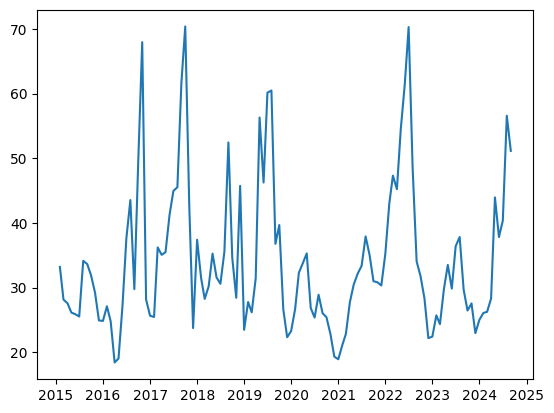

In [250]:
import matplotlib
from matplotlib import pyplot as plt
plt.plot(sic_data);plt.show()